<a href="https://colab.research.google.com/github/idnm/FourierVQA/blob/master/experiments.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Imports and setup.

When running on Colab

In [ ]:
!wget https://raw.githubusercontent.com/idnm/FourierVQA/master/fourier_vqa.py
!wget https://raw.githubusercontent.com/idnm/FourierVQA/master/experiments_utils.py

!pip install qiskit

Imports

In [1]:
import matplotlib.pyplot as plt
from scipy.special import binom
from functools import partial

from qiskit import QuantumCircuit
from qiskit.circuit import Parameter
from qiskit.quantum_info import Clifford
from qiskit.circuit.library import TwoLocal

from fourier_vqa import *
from experiments_utils import *

import networkx as nx
import os
import dill

from pandas import DataFrame

# Basic usage example

Here is a brief illustration of how to compute a Fourier series expansion.

In [ ]:
# Define a parameterized quantum circuit and a Pauli observable.
num_qubits = 20

qc = TwoLocal(num_qubits, rotation_blocks='ry', entanglement_blocks='cz', entanglement='linear', reps=7).decompose()
observable = Pauli('ZX'+'I'*(num_qubits-2))

# Parameterized quantum circuit needs to be parsed and transformed into the form containing Pauli rotations only.
pauli_circuit = PauliCircuit.from_parameterized_circuit(qc)

# A Pauli circuit and an observable is the input to the Fourier series computation.
fourier_expansion = FourierExpansionVQA(pauli_circuit, observable)
fourier_expansion.compute() # verbose=False to supress the progress bar.

Δ=100.00% norm absolute=0.17 norm relative=100.00% #nodes=0.00e+00:   9%|▉         | 15/160 [00:15<02:25,  1.00s/it]


Quantities reported in the progress bar are:
- $\Delta=\sum_{k=0}^m 2^{-k} n(k)$ with $n(k)$ the number of final observables at level $k$. Quantifies coverage of the computational tree.
- norm absolute = $\sum_{k=0}^m 2^{-k} l(k)$ with $l(k)$ number of final observables at level $k$ with non-zero expectation value. Norm of the loss function truncated at level $m$.
- norm relative, computes the relative norm computed up to to the current level, assuming that all final observables at higher levels have non-zero expectation values (usually seriously underestimated).
- #nodes is the number of computational nodes at the current step.

We check that Fourier expansion reproduces values of the loss function correctly.

In [ ]:
# Sample random parameters.
np.random.seed(0)
random_angles = np.random.uniform(0, 2*np.pi, size=(qc.num_parameters))
# Because of the possible ordering ambiguity, we need to pass parameter values as dict.
random_parameters = {p: val for p, val in zip(qc.parameters, random_angles)} 

# Verify against the statevector simulation.
state = Statevector(qc.bind_parameters(random_parameters))
print('Statevector value:', state.expectation_value(observable))
print('Fourier value:', fourier_expansion.evaluate_loss_at(random_parameters))

Statevector value: 0.5618203770612684
Fourier value: 0.5618203770612659


Visualize distribution of the Fourier terms.

number Fourier coefficients: 3432


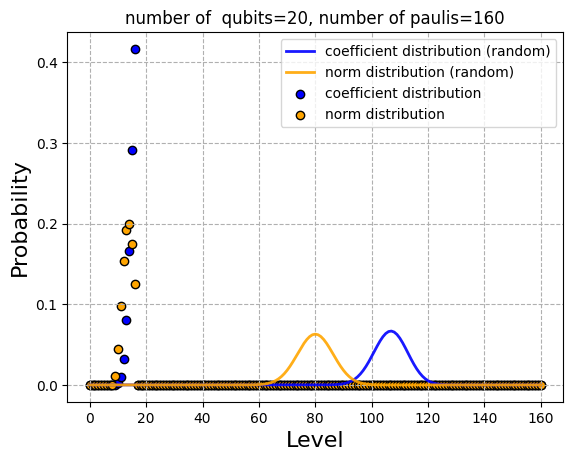

In [ ]:
# Statistics for the loss function (set only_nonzero=False to get statistics for all computational nodes instead).
stats = fourier_expansion.stats(only_nonzero=True) 
print('number Fourier coefficients:', stats.num_nodes)
stats.plot()

# Random circuits

## Level statistics for fully random circuits

We now collect statistics on the distribution of terms in the dressed Hamiltonian for random circuits.

In [ ]:
num_qubits = 30
num_paulis = 25
num_samples = 20

np.random.seed(42)
seeds = np.random.randint(0, 2**32, num_samples)

fourier_stats_samples = []

for seed in tqdm(seeds):
    fourier_computation = FourierExpansionVQA.random(num_qubits, num_paulis, seed)
    # check_admissible=False to get the full expansion of the dressed Hamiltonian
    fourier_computation.compute(check_admissible=False, verbose=False)    
    fourier_stats_samples.append(fourier_computation.stats())

100%|██████████| 20/20 [01:54<00:00,  5.70s/it]


And visualize it.

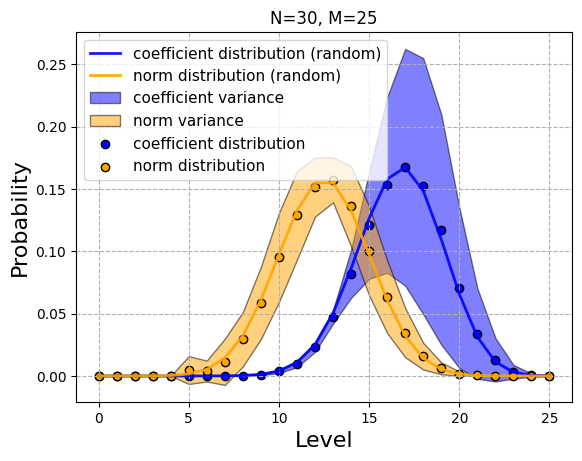

In [ ]:
FourierStats.plot_several(fourier_stats_samples)
plt.title(f'N={num_qubits}, M={num_paulis}');
plt.legend(fontsize=11)
# plt.savefig('tex/figures/random.png', dpi=1000)

## Level statistics for local circuits with random observables

We repeat the computation above, but now only the observale is fully random. Pauli gates are local, bounded by `weight`. The result is that the average distribution of nodes is indeed the same as for the fully random circuits, but with a noticably higher variance.

In [46]:
np.random.seed(42)

num_qubits = 30
num_paulis = 25
num_samples = 100

weigth = 2  # Weight of each local pauli gate.

fourier_stats_samples = []
for seed in tqdm(range(num_samples)):
    seed_circuit, seed_observable = np.random.randint(0, 2**32, 2)
    
    pauli_circuit = random_local_pauli_circuit(num_qubits, num_paulis, weigth, seed_circuit)
    observable = random_pauli(num_qubits, seed=seed_observable)

    fourier_computation = FourierExpansionVQA(pauli_circuit, observable)
    # check_admissible=False to get the full expansion of the dressed Hamiltonian
    fourier_computation.compute(check_admissible=False, verbose=False)    
    fourier_stats_samples.append(fourier_computation.stats())

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [04:54<00:00,  2.95s/it]


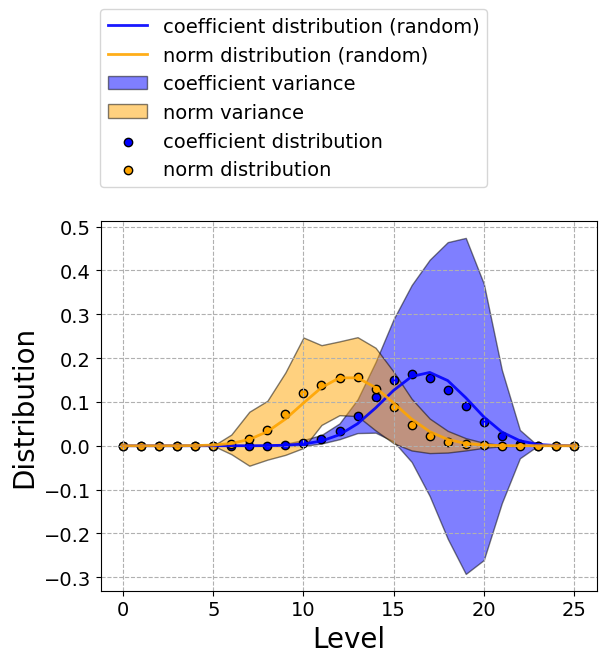

In [47]:
plt.rcParams.update({'font.size': 14})
FourierStats.plot_several(fourier_stats_samples)
plt.ylabel('Distribution', fontsize=20)
plt.xlabel('Level', fontsize=20)
# plt.title(f'N={num_qubits}, M={num_paulis}');
plt.legend(bbox_to_anchor=(-0.02, 1.6), loc='upper left');
plt.savefig('tex/figures/random_local_nodes.png', bbox_inches="tight", dpi=1000)

## Estimating complexity of the algorithm

Now let us look at how the complexity of the algorithm scales. For this, we use monte-carlso sampling instead of the full computation and also make prunings of the branches based on the expectation values.

In [ ]:
np.random.seed(0)

num_samples_monte_carlo = 10**3
num_sample_circuits = 5

max_num_qubits = 100
step_size = 10
qubits = list(range(5, max_num_qubits+1, step_size))
num_computational_nodes = np.zeros((num_sample_circuits, len(qubits)))

for i, num_qubits in tqdm(list(enumerate(qubits))):
    num_paulis = int(np.ceil(num_qubits/np.log2(3/2)))
    seeds = np.random.randint(0, 2**32, num_sample_circuits)
    for j, seed in enumerate(seeds):
        fourier_expansion = FourierExpansionVQA.random(num_qubits, num_paulis, seed)
        num_nodes, _ = fourier_expansion.estimate_node_count_monte_carlo(
            num_samples=num_samples_monte_carlo, 
            check_admissible=True, 
            verbose=False)
        num_computational_nodes[j, i] = num_nodes

100%|██████████| 10/10 [02:08<00:00, 12.82s/it]


Now we visualize the data and compare to the theoretical predictions.

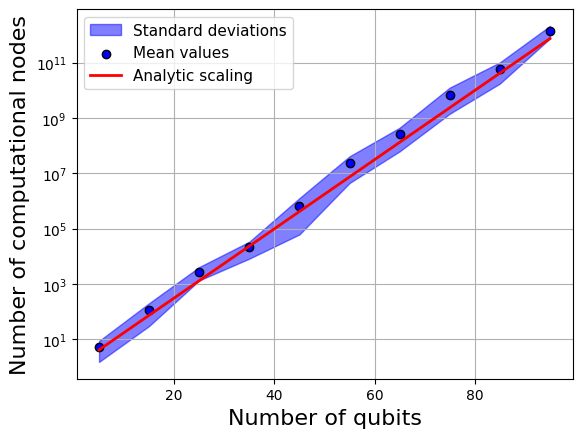

In [ ]:
node_means = np.mean(num_computational_nodes, axis=0)
node_variance = np.std(num_computational_nodes, axis=0)

plt.fill_between(qubits, node_means+node_variance, node_means-node_variance, color='blue', alpha=0.5, label='Standard deviations')
plt.scatter(qubits, node_means, color='blue', edgecolors='black', label='Mean values')
plt.plot(qubits, (1.5)**(np.array(qubits)*(1/np.log2(3/2)-1)), color='red', linewidth=2, label='Analytic scaling')
plt.xlabel('Number of qubits', fontsize=16)
plt.ylabel('Number of computational nodes', fontsize=16)
plt.grid()
plt.legend(fontsize=11)
plt.yscale('log')
#plt.savefig('tex/figures/random_mc.png')

# QAOA

We will need the size of the reverse light cone.

In [36]:
def reverse_light_cone_size(d, p):
    if d<2:
        raise ValueError
    elif d==2:
        return int(2*p+2)
    else:
        return int(2*((d-1)**(p+1)-1)/(d-2))

## Estimating number of computational nodes.

**!!Warning!!** Computation in this subsections takes hours to run.

In [ ]:
np.random.seed(0)

num_samples_monte_carlo = 10000
num_sample_circuits = 20

max_level = 4
max_degree = 4

num_computational_nodes = np.zeros((num_sample_circuits, max_degree-1, max_level))

for p in tqdm(range(1, max_level+1)):                                         
    for d in range(2, max_degree+1):
        for s in range(num_sample_circuits):
            num_qubits = reverse_light_cone_size(d, p)
            graph = nx.random_regular_graph(d, num_qubits, seed=int(np.random.randint(0, 2**32)))
            qaoa = QAOA(graph, p)

            observables = qaoa.observables()
            observable = observables[np.random.randint(0, len(observables))]

            fourier_expansion = FourierExpansionVQA(PauliCircuit.from_parameterized_circuit(qaoa.circuit()), observable)
            num_nodes, _ = fourier_expansion.estimate_node_count_monte_carlo(
                num_samples=num_samples_monte_carlo, 
                check_admissible=True, 
                verbose=False,
                seed=np.random.randint(0, 2**32))
                                         
            num_computational_nodes[s, d-2, p-1] = num_nodes

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4/4 [8:49:03<00:00, 7936.00s/it]


Means.

In [ ]:
num_nodes_means = np.mean(np.log10(num_computational_nodes), axis=0)

idx = range(2, max_degree+1)
cols = range(1, max_level+1)
title = 'd \ p'

df_means = DataFrame(num_nodes_means, index=idx, columns=cols)
df_means.style.set_caption('d\p')

,1,2,3,4
2,0.716486,1.477585,3.398900,4.741511
3,1.070407,3.613237,8.630480,17.477228
4,1.374423,5.650029,16.351293,36.643371


Deviations.

In [ ]:
num_nodes_deviations = np.std(np.log10(num_computational_nodes), axis=0)

df_std = DataFrame(num_nodes_deviations, index=idx, columns=cols)
df_std.style.set_caption('d\p')

,1,2,3,4
2,0.083975,0.896111,1.686667,2.605148
3,0.142871,0.362477,0.943236,2.236700
4,0.319208,0.454445,1.272623,3.037631


## Distribution of Fourier terms by level

Here we look at the distrubution of terms in the loss function by level for a specific example of $p=2, d=3$ QAOA (averaged over different graphs and observables).

In [44]:
np.random.seed(42)

d = 3
p = 2
num_qubits = reverse_light_cone_size(d, p)

num_samples = 100

fourier_stats_samples_all = []
fourier_stats_samples_nonzero = []
for i in tqdm(range(num_samples)):
    graph = nx.random_regular_graph(d, num_qubits, seed=int(np.random.randint(0, 2**32)))
    qaoa = QAOA(graph, p)

    observables = qaoa.observables()
    observable = observables[np.random.randint(0, len(observables))]
    
    fourier_expansion = FourierExpansionVQA(PauliCircuit.from_parameterized_circuit(qaoa.circuit()), observable)
    fourier_expansion.compute(check_admissible=True, verbose=False)
    fourier_stats_samples_all.append(fourier_expansion.stats(only_nonzero=False))
    fourier_stats_samples_nonzero.append(fourier_expansion.stats(only_nonzero=True))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [06:55<00:00,  4.15s/it]


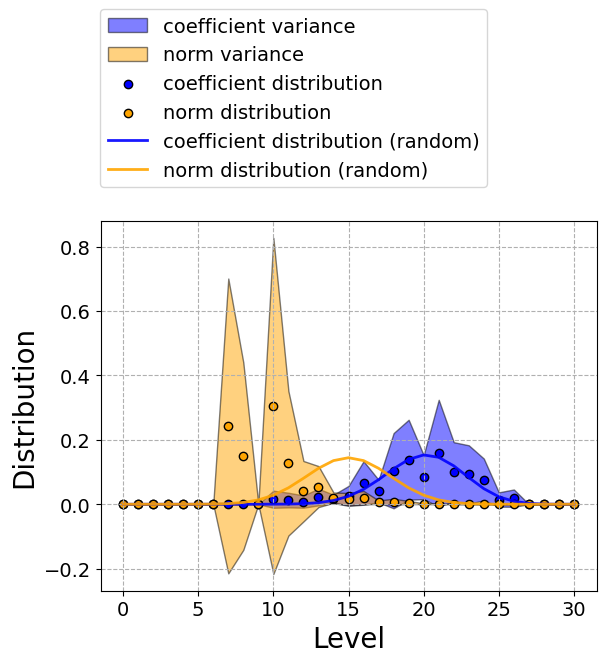

In [48]:
plt.rcParams.update({'font.size': 14})
FourierStats.plot_several(fourier_stats_samples_nonzero, plot_random=False, max_level=30)
FourierStats.plot_random(30)
plt.ylabel('Distribution', fontsize=20)
plt.xlabel('Level', fontsize=20)
# plt.title(f'N={num_qubits}, M={num_paulis}');
plt.legend(bbox_to_anchor=(-0.02, 1.6), loc='upper left');
plt.savefig('tex/figures/qaoa_complexity.png', bbox_inches="tight", dpi=1000)

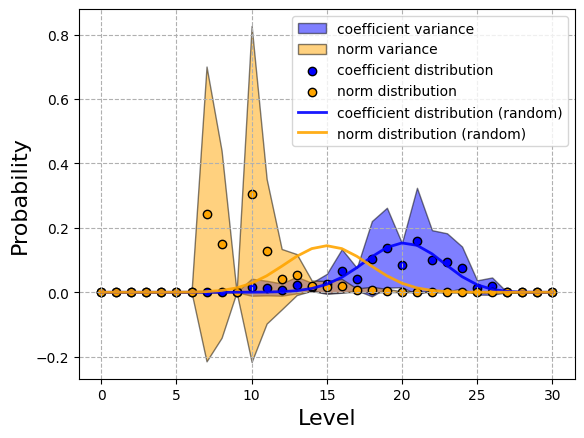

In [ ]:
FourierStats.plot_several(fourier_stats_samples_nonzero, plot_random=False, max_level=30)
FourierStats.plot_random(30)
plt.legend();
#plt.savefig('tex/figures/qaoa_complexity.png', dpi=1000)

# Hardware-efficient ansatz

## Estimating the number of computational nodes

We collect Monte-Carlo estimates of the complexity of the algorithm to compute the full Fourier series of a brickwall hardware-efficient circuit with 50 qubits at various depths.

**!!Warning!!** This computation takes about an hour to run.

In [ ]:
np.random.seed(0)

num_samples_monte_carlo = 10**4
num_sample_circuits = 10

num_qubits = 50
M_points = [10]+list(range(100, 600+1, 100))

num_computational_nodes = np.zeros((num_sample_circuits, len(M_points)))

for i, M in tqdm(list(enumerate(M_points))):

    seeds = np.random.randint(0, 2**32, num_sample_circuits)
    for j, seed in enumerate(seeds):
        circuit = brickwall_circuit(num_qubits, M//4)
        observable = random_local_pauli(num_qubits, 2, seed) # Weight=2
        fourier_expansion = FourierExpansionVQA(
            PauliCircuit.from_parameterized_circuit(circuit),
            observable)
        num_nodes, _ = fourier_expansion.estimate_node_count_monte_carlo(
            num_samples=num_samples_monte_carlo, 
            check_admissible=True, 
            verbose=False)
        num_computational_nodes[j, i] = num_nodes

100%|██████████| 7/7 [1:23:10<00:00, 712.86s/it] 


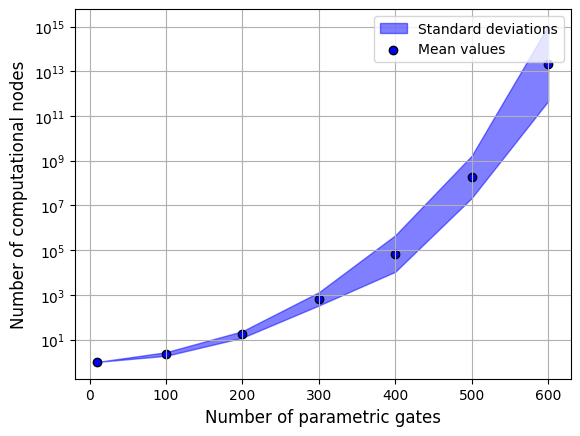

In [ ]:
exponents_mean = np.mean(np.log10(num_computational_nodes), axis=0)
exponents_variance = np.std(np.log10(num_computational_nodes), axis=0)

plt.fill_between(M_points, 10**(exponents_mean+exponents_variance), 10**(exponents_mean-exponents_variance), color='blue', alpha=0.5, label='Standard deviations')
plt.scatter(M_points, 10**(exponents_mean), color='blue', edgecolors='black', label='Mean values')
plt.xlabel('Number of parametric gates', fontsize=12)
plt.ylabel('Number of computational nodes', fontsize=12)
plt.grid()
plt.legend()
plt.yscale('log')
# plt.savefig('tex/figures/hea.png')

## Distribution of Fourier terms by level

For a particular depth with $304$ parametric gates we also collect the statistics on the distribution of Fourier terms in the loss function. Averages and variations are computed over 100 different two-local Pauli observables.

In [39]:
np.random.seed(0)

num_qubits = 50
num_paulis = 304
num_samples = 100

circuit = brickwall_circuit(num_qubits, num_paulis//4)
pauli_circuit = PauliCircuit.from_parameterized_circuit(circuit)

fourier_stats_samples_all = []
fourier_stats_samples_nonzero = []
for _ in tqdm(range(num_samples)):
        observable = random_local_pauli(num_qubits, 2, seed=np.random.randint(0, 2**32)) # Weight=2
        fourier_expansion = FourierExpansionVQA(pauli_circuit, observable)
        fourier_expansion.compute(check_admissible=True, verbose=False)
        fourier_stats_samples_all.append(fourier_expansion.stats(only_nonzero=False))
        fourier_stats_samples_nonzero.append(fourier_expansion.stats(only_nonzero=True))

100%|███████████████████████████████████████████████████████████████████████████████████████████████████████| 100/100 [03:12<00:00,  1.92s/it]


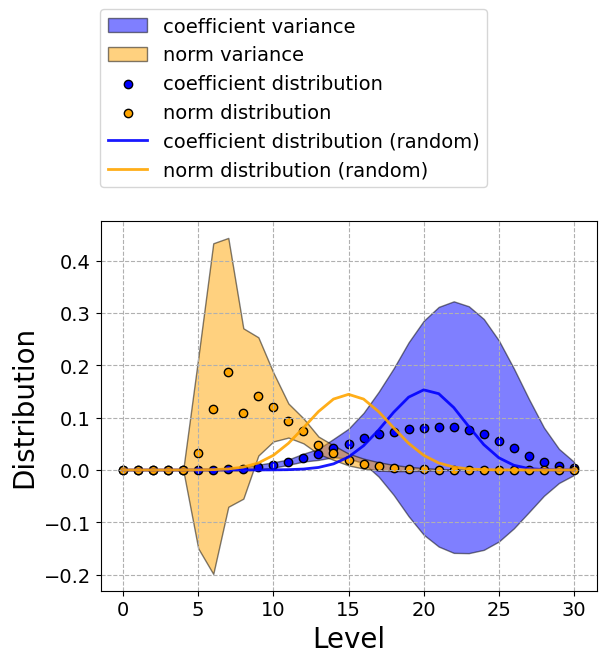

In [43]:
plt.rcParams.update({'font.size': 14})
FourierStats.plot_several(fourier_stats_samples_nonzero, plot_random=False, max_level=30)
FourierStats.plot_random(30)
plt.ylabel('Distribution', fontsize=20)
plt.xlabel('Level', fontsize=20)
# plt.title(f'N={num_qubits}, M={num_paulis}');
plt.legend(bbox_to_anchor=(-0.02, 1.6), loc='upper left');
plt.savefig('tex/figures/HEA_nodes.png', bbox_inches="tight", dpi=1000)

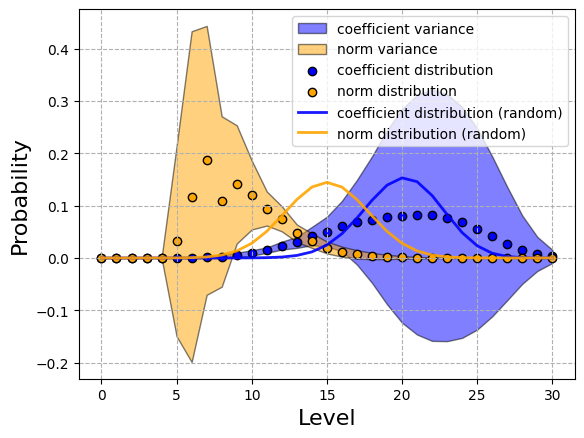

In [ ]:
FourierStats.plot_several(fourier_stats_samples_nonzero, plot_random=False, max_level=30)
FourierStats.plot_random(30)
plt.legend();
#plt.savefig('tex/figures/HEA_nodes.png', dpi=1000)